# VGG-11 implementation and fine-tuning
- boostcamp-AI 과제 정리입니다.


In [1]:
# install quickdraw python API
!pip3 install quickdraw

In [2]:
# !pip install torch==1.9.0
# !pip install torchvision==0.10.0
# print(torch.__version__)

In [3]:
# import packages
from quickdraw import QuickDrawData, QuickDrawDataGroup
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import itertools
import matplotlib.pyplot as plt
import os
import numpy as np
import torch.nn as nn
import pandas as pd

In [4]:
# fix random seeds
import random
random.seed(100)
torch.manual_seed(0)
# torch.manual_seed(seed) # cpu 연산 무작위 고정 
# torch.cuda.manual_seed(seed) # gpu 연산 무작위 고정 
# torch.cuda.manual_seed_all(seed) # 멀티 gpu 연산 무작위 고정 
# np.random.seed(~~) # numpy 관련 연산 무작위 고정 

In [5]:
num_img_per_class = 3000 
qd = QuickDrawData(max_drawings=num_img_per_class)

In [6]:
class_list = ['apple', 'wine bottle', 'spoon', 'rainbow', 'panda', 'hospital', 'scissors', 'toothpaste', 'baseball', 'hourglass']
class_dict = {'apple' : 0, 'wine bottle' : 1, 'spoon' : 2, 'rainbow' : 3, 'panda': 4, 'hospital' : 5, 'scissors' : 6, 'toothpaste' : 7, 'baseball' : 8, 'hourglass' : 9}

In [7]:
qd.load_drawings(class_list)

loading apple drawings
load complete
loading wine bottle drawings
load complete
loading spoon drawings
load complete
loading rainbow drawings
load complete
loading panda drawings
load complete
loading hospital drawings
load complete
loading scissors drawings
load complete
loading toothpaste drawings
load complete
loading baseball drawings
load complete
loading hourglass drawings
load complete


In [8]:
# get images, and append to train(90%)/validation(10%) data and label list
train_data = list()
val_data = list()
train_label = list()
val_label = list()
for class_name in class_list:
    qdgroup = QuickDrawDataGroup(class_name, max_drawings=num_img_per_class)
    for i, img in enumerate(qdgroup.drawings):
        if i < int(0.9 * num_img_per_class):
            train_data.append(np.asarray(img.get_image()))
            train_label.append(class_dict[class_name])
        else:
            val_data.append(np.asarray(img.get_image()))
            val_label.append(class_dict[class_name])

loading apple drawings
load complete
loading wine bottle drawings
load complete
loading spoon drawings
load complete
loading rainbow drawings
load complete
loading panda drawings
load complete
loading hospital drawings
load complete
loading scissors drawings
load complete
loading toothpaste drawings
load complete
loading baseball drawings
load complete
loading hourglass drawings
load complete


In [10]:
print(len(train_data),len(val_data))

27000 3000


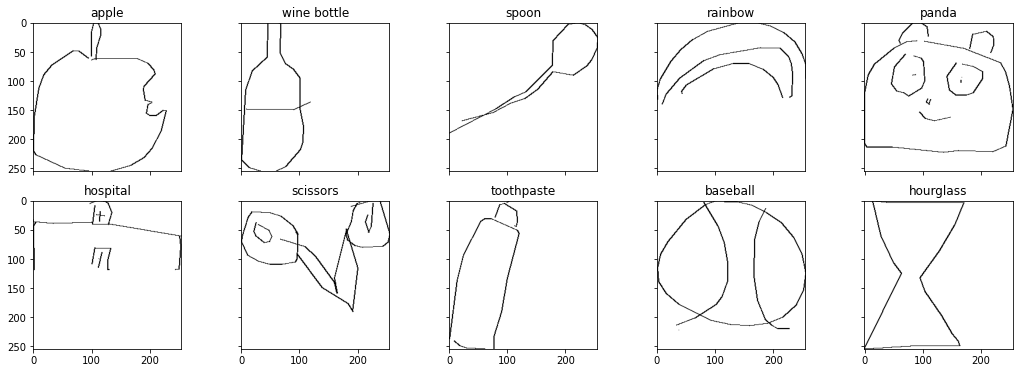

In [9]:
# plt.imshow(train_data[0])
fig, axes = plt.subplots(2,5, sharex = True, sharey = True, figsize = (18,6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(train_data[i*2700+1])
    ax.set_title(f'{class_list[train_label[i*2700+1]]}')
    
plt.show()
# 회전하는 transform이 효과 좋을 수도 있을듯. (패딩 생김 주의)

## affine transfromation 적용하면?

In [10]:
#!pip install opencv-python
import cv2

In [11]:
rows, cols, ch = train_data[1].shape
pts1 = np.float32([[50,50],[200,50],[50,200]])
pts2 = np.float32([[10,100],[200,50],[100,250]])
M = cv2.getAffineTransform(pts1,pts2)
shear_img = cv2.warpAffine(train_data[1], M, (cols, rows))

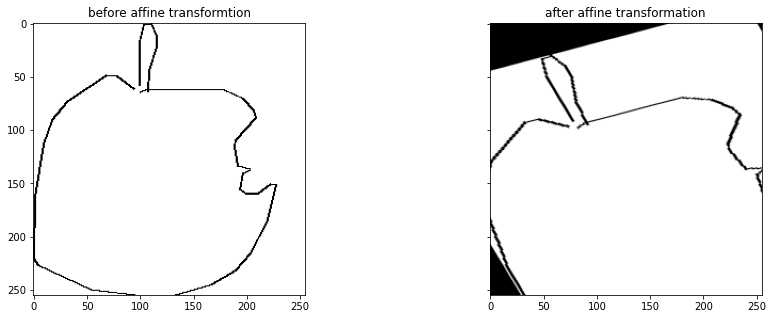

In [13]:
fig, axes = plt.subplots(1,2, sharex=True, sharey=True, figsize=(15,5))
axes[0].imshow(train_data[1])
axes[0].set_title('before affine transformtion')

axes[1].imshow(shear_img)
axes[1].set_title('after affine transformation')

plt.show()
# 검정색 영역이 학습에 악영향? 패딩과 유사해서 상관없음?
# Conv관점에선 local한 특징을 보니까 패턴으로 학습되지 않으려나..
# 단지 규칙적인 방향으로 와핑하는건 주의해야할듯

In [15]:
# transformation, image to (224, 224) tensor
transform = transforms.Compose([
    #transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 이미지넷으로 학습된 모델이라 이미지넷의 RGB mean, std
                          std=[0.229, 0.224, 0.225])
])

주어진 데이터의 RGB mean과 std값을 구해봄.

In [17]:
img_info = {'means' : [], 'stds': []}
def get_img_stats(img, img_info):
    """이미지의 mean, std를 img_info에 저장"""
    h, w, _ = img.shape
    img_info['means'].append(img.mean(axis=(0,1)))
    img_info['stds'].append(img.std(axis=(0,1)))

from tqdm.notebook import tqdm
for i in tqdm(range(len(train_data))):
    get_img_stats(train_data[i], img_info)

In [18]:
print(f'RGB Mean: {np.mean(img_info["means"], axis=0) / 255.}')
print(f'RGB Standard Deviation: {np.mean(img_info["stds"], axis=0) / 255.}')

RGB Mean: [0.97333386 0.97333386 0.97333386]
RGB Standard Deviation: [0.15715932 0.15715932 0.15715932]


In [19]:
transform_QuickDrawData = transforms.Compose([
    #transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.Normalize(mean=np.mean(img_info["means"], axis=0) / 255., # 이미지넷으로 학습된 모델이라 이미지넷의 RGB mean, std
                          std=np.mean(img_info["stds"], axis=0) / 255.)
])

In [20]:
# custom dataset for Quickdraw
class QuickDrawDataset(Dataset):

    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

In [22]:
# quickdraw train/validatoin dataset and dataloader
qd_train_dataset = QuickDrawDataset(train_data, train_label, transform)
qd_val_dataset = QuickDrawDataset(val_data, val_label, transform)

qd_train_dataloader = DataLoader(qd_train_dataset, batch_size=64, shuffle=True)
qd_val_dataloader = DataLoader(qd_val_dataset, batch_size=64, shuffle=True)

In [23]:
class AverageMeter(object):
  """Computes and stores the average and current value"""
  def __init__(self):
      self.reset()

  def reset(self):
    self.val = 0
    self.avg = 0
    self.sum = 0
    self.count = 0

  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

## Custom VGG-11 implementation

아래 Table은 여러 종류의 VGG 네트워크에 대한 각각의 구성을 나타낸 것입니다.
<br>A에서 E까지 다양한 크기의 VGG 중에서 구현하고자 하는 네트워크는 **A에 해당하는 VGG-11**입니다.

----

<img src='https://drive.google.com/uc?id=1bFKnmwcbdJLQdCjNPxQdaYnTNCmBt0rK'  width="700">

----
구현한 VGG-11에 문제가 없다면 네트워크의 **output tensor는 10-dim vector**에 해당해야 합니다. 

<br>아래의 코드를 실행하여 **output tensor의 shape을 확인**해봅시다.
<br> 만약 ```out = model_test(x)```를 실행하였을 때 오류가 발생한다면 layer 구현에 오류가 있는 것이니 다시 한번 네트워크 코드에 문제가 없는지 확인해보세요 :)


아래의 문구와 동일하게 출력된다면 output tensor의 shape이 알맞게 return된 것입니다!
```python
"Output tensor shape is : torch.Size([1, 10])"
```

In [55]:
import torch
import torch.nn as nn

class VGG11(nn.Module):
  def __init__(self, num_classes=10):
    super(VGG11, self).__init__()

    self.relu = nn.ReLU(inplace=True)
    
    # Convolution Feature Extraction Part
    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
    self.bn1   = nn.BatchNorm2d(64)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    # TO DO (1-1) starts here!
    # Fill empty parts with proper code
    self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.bn2   = nn.BatchNorm2d(128)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
    self.bn3_1   = nn.BatchNorm2d(256)
    self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
    self.bn3_2   = nn.BatchNorm2d(256)
    self.pool3   = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
    self.bn4_1   = nn.BatchNorm2d(512)
    self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.bn4_2   = nn.BatchNorm2d(512)
    self.pool4   = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.bn5_1   = nn.BatchNorm2d(512)
    self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.bn5_2   = nn.BatchNorm2d(512)
    self.pool5   = nn.MaxPool2d(kernel_size=2, stride=2)
    # TO DO (1-1) ends here!

    # Fully Connected Classifier Part
    # TO DO (1-2) starts here!
    # Fill empty parts with proper code
    self.fc1      = nn.Linear(25088, 4096) #이렇게 숫자로 입력하는거 맞음?
    self.dropout1 = nn.Dropout()
    self.fc2      = nn.Linear(4096, 4096)
    self.dropout2 = nn.Dropout()
    
    self.fc3      = nn.Linear(4096, 10)
    # TO DO (1-2) ends here!

  def forward(self, x):
    # Convolution Feature Extraction Part
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.pool1(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    x = self.pool2(x)

    x = self.conv3_1(x)
    x = self.bn3_1(x)
    x = self.relu(x)
    x = self.conv3_2(x)
    x = self.bn3_2(x)
    x = self.relu(x)
    x = self.pool3(x)

    x = self.conv4_1(x)
    x = self.bn4_1(x)
    x = self.relu(x)
    x = self.conv4_2(x)
    x = self.bn4_2(x)
    x = self.relu(x)
    x = self.pool4(x)

    x = self.conv5_1(x)
    x = self.bn5_1(x)
    x = self.relu(x)
    x = self.conv5_2(x)
    x = self.bn5_2(x)
    x = self.relu(x)
    x = self.pool5(x)

    # part to help debugging by checking tensor size
    # delete or comment out this line after debugging
    # Model의 feed forward를 수행하는 과정에서 해당 부분의 tensor shape가 출력되므로, 
    # 이 정보를 이용해 fully connected layer의 input dimension을 계산 할 수 있음. 
    # print(f'Tensor shape after convolution layers is {x.shape}')

    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.dropout1(x)
    
    x = self.fc2(x)
    x = self.relu(x)
    x = self.dropout2(x)
    
    x = self.fc3(x)
    return x

In [25]:
# Network
model_test = VGG11(num_classes=10)

# Random input
x = torch.randn((1, 3, 224, 224)) #batchsize, channel, h, w

# Forward
out = model_test(x)

# Check the output shape
print("Output tensor shape is :", out.shape)

Output tensor shape is : torch.Size([1, 10])


/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [34]:
# Build user-defined VGG model
model_scratch = VGG11(num_classes=10)

In [35]:
# Loss function and Optimizer
from torch.optim import Adam

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model_scratch.parameters(), lr=1e-4)

In [28]:
log_dir ='./log'

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [36]:
# Main
os.makedirs(log_dir, exist_ok=True)

with open(os.path.join(log_dir, 'scratch_train_log.csv'), 'w') as log: # csv파일에 train log 남김

  # set model to train mode
  model_scratch.train()
  for iter, (img, label) in enumerate(qd_train_dataloader):

    # optimizer에 저장된 미분값을 0으로 초기화
    optimizer.zero_grad()

    img, label = img.to(device), label.to(device) 
    model_scratch.to(device)
    
  
    # 모델에 이미지 forward
    pred_logit = model_scratch(img)

    # loss 값 계산
    loss = criterion(pred_logit, label) 

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Accuracy 계산
    pred_label = torch.argmax(pred_logit, 1)
    acc = (pred_label == label).sum().item() / len(img)

    train_loss = loss.item()
    train_acc = acc

    # Validation 
    if (iter % 20 == 0) or (iter == len(qd_train_dataloader)-1):

      # set model to validation mode
      model_scratch.eval()
      valid_loss, valid_acc = AverageMeter(), AverageMeter()

      for img, label in qd_val_dataloader:
     
        img, label = img.to(device), label.to(device)

        # 모델에 이미지 forward (gradient 계산 X)
        with torch.no_grad():
          pred_logit = model_scratch(img)

        # loss 값 계산
        loss = criterion(pred_logit, label) 


        # Accuracy 계산
        pred_label = torch.argmax(pred_logit, 1)
        acc = (pred_label == label).sum().item() / len(img)

        valid_loss.update(loss.item(), len(img))
        valid_acc.update(acc, len(img))

      valid_loss = valid_loss.avg
      valid_acc = valid_acc.avg

      print("Iter [%3d/%3d] | Train Loss %.4f | Train Acc %.4f | Valid Loss %.4f | Valid Acc %.4f" %
            (iter, len(qd_train_dataloader), train_loss, train_acc, valid_loss, valid_acc))
      
      # Train Log Writing
      log.write('%d,%.4f,%.4f,%.4f,%.4f\n'%(iter, train_loss, train_acc, valid_loss, valid_acc))

Iter [  0/422] | Train Loss 2.3369 | Train Acc 0.1094 | Valid Loss 2.3025 | Valid Acc 0.1000
Iter [ 20/422] | Train Loss 2.2639 | Train Acc 0.0469 | Valid Loss 2.2066 | Valid Acc 0.2407
Iter [ 40/422] | Train Loss 1.5609 | Train Acc 0.3594 | Valid Loss 1.5045 | Valid Acc 0.5130
Iter [ 60/422] | Train Loss 0.6968 | Train Acc 0.7812 | Valid Loss 1.2165 | Valid Acc 0.6190
Iter [ 80/422] | Train Loss 0.8994 | Train Acc 0.7188 | Valid Loss 0.8940 | Valid Acc 0.7243
Iter [100/422] | Train Loss 0.7391 | Train Acc 0.7344 | Valid Loss 0.7421 | Valid Acc 0.7707
Iter [120/422] | Train Loss 1.0567 | Train Acc 0.6875 | Valid Loss 0.6942 | Valid Acc 0.7877
Iter [140/422] | Train Loss 0.6439 | Train Acc 0.7969 | Valid Loss 0.6463 | Valid Acc 0.7963
Iter [160/422] | Train Loss 0.5834 | Train Acc 0.7656 | Valid Loss 0.5679 | Valid Acc 0.8250
Iter [180/422] | Train Loss 0.3520 | Train Acc 0.9375 | Valid Loss 0.5566 | Valid Acc 0.8383
Iter [200/422] | Train Loss 0.3217 | Train Acc 0.9219 | Valid Loss 0.5

In [37]:
from torchsummary import summary

summary(model_scratch, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
         MaxPool2d-4         [-1, 64, 112, 112]               0
            Conv2d-5        [-1, 128, 112, 112]          73,856
       BatchNorm2d-6        [-1, 128, 112, 112]             256
              ReLU-7        [-1, 128, 112, 112]               0
         MaxPool2d-8          [-1, 128, 56, 56]               0
            Conv2d-9          [-1, 256, 56, 56]         295,168
      BatchNorm2d-10          [-1, 256, 56, 56]             512
             ReLU-11          [-1, 256, 56, 56]               0
           Conv2d-12          [-1, 256, 56, 56]         590,080
      BatchNorm2d-13          [-1, 256, 56, 56]             512
             ReLU-14          [-1, 256,

## Fine-tuning VGG-11 with pretrained feature extractor
이번에는 torchvision에서 제공하는 pretrained VGG-11을 이용한 fine-tuning 학습을 진행하게 됩니다. Fine-tuning의 경우도 기본적인 training 방법은 동일하지만, 이번에는 모든 parameter를 처음부터 학습하는 대신 **feature extractor는 기존 학습된 상태에서 고정하고 linear classifier만 새로 학습**한다는 차이가 있습니다. 

- validation을 수행할 때는 gradient 계산 및 backpropagation이 필요 없음 주의
- Linear classifier만을 학습하기 위해, convolution layers들의 weight를 freeze 하기

- Hint : Google에 *how to freeze conv layers* 를 검색한 [결과](https://www.google.com/search?q=how+to+freeze+conv+layers&oq=how+to+&aqs=chrome.0.69i59j69i57j0i512l3j69i60l3.809j0j7&sourceid=chrome&ie=UTF-8) 나오는 [stackoverflow 글](https://discuss.pytorch.org/t/how-the-pytorch-freeze-network-in-some-layers-only-the-rest-of-the-training/7088)을 참고하면 쉽게 구현할 수 있습니다. 이와 같이, 필요한 내용을 잘 googling하는 실력은 앞으로의 개발 과정에서도 필수적인 능력이 될 것입니다. 앞으로를 위해 **정확한 키워드로 잘 검색하는 습관**을 들이시면 모든 함수를 외우지 않고도 효율적이고 빠른 코딩이 가능할 것입니다.

In [40]:
from torchvision.models import vgg11

pretrained = True 
model_finetune = vgg11(pretrained)


# change VGG-11's output dimension to 10
model_finetune.classifier[6] = nn.Linear(4096, 10)

# Freeze the feature extracting convolution layers
for param in model_finetune.parameters():
    param.requires_grad = False

for param in model_finetune.classifier.parameters():
    param.requires_grad = True


In [41]:
# Loss function and Optimizer
from torch.optim import Adam

criterion = nn.CrossEntropyLoss()
optimizer_ft = Adam(model_finetune.parameters(), lr=1e-4)

In [46]:
# Main
os.makedirs(log_dir, exist_ok=True)

with open(os.path.join(log_dir, 'fine_tuned_train_log.csv'), 'w') as log:
  # Training

  # set model to train mode
  model_finetune.train()
  for iter, (img, label) in enumerate(qd_train_dataloader):

    # optimizer에 저장된 미분값을 0으로 초기화
    optimizer_ft.zero_grad()

    img, label = img.to(device), label.to(device)
    model_finetune.to(device)
  
    # 모델에 이미지 forward
    pred_logit = model_finetune(img)

    # loss 값 계산
    loss = criterion(pred_logit, label)

    # Backpropagation
    loss.backward()
    optimizer_ft.step()
    # TO DO (3-1) ends here!

    # Accuracy 계산
    pred_label = torch.argmax(pred_logit, 1)
    acc = (pred_label == label).sum().item() / len(img)

    train_loss = loss.item()
    train_acc = acc

    # Validation 
    if (iter % 20 == 0) or (iter == len(qd_train_dataloader)-1):
      # TO DO (3-2) starts here!
      # Fill empty parts with proper code

      # set model to validation mode
      model_finetune.eval()
      valid_loss, valid_acc = AverageMeter(), AverageMeter()

      for img, label in qd_val_dataloader:

        img, label = img.to(device), label.to(device)

        # 모델에 이미지 forward (gradient 계산 X)
        with torch.no_grad():
          pred_logit = model_finetune(img)

        # loss 값 계산
        loss = criterion(pred_logit, label)

        # TO DO (3-2) ends here!

        # Accuracy 계산
        pred_label = torch.argmax(pred_logit, 1)
        acc = (pred_label == label).sum().item() / len(img)

        valid_loss.update(loss.item(), len(img))
        valid_acc.update(acc, len(img))

      valid_loss = valid_loss.avg
      valid_acc = valid_acc.avg

      print("Iter [%3d/%3d] | Train Loss %.4f | Train Acc %.4f | Valid Loss %.4f | Valid Acc %.4f" %
            (iter, len(qd_train_dataloader), train_loss, train_acc, valid_loss, valid_acc))
      
      # Train Log Writing
      log.write('%d,%.4f,%.4f,%.4f,%.4f\n'%(iter, train_loss, train_acc, valid_loss, valid_acc))

Iter [  0/422] | Train Loss 2.7021 | Train Acc 0.0781 | Valid Loss 2.2370 | Valid Acc 0.1797
Iter [ 20/422] | Train Loss 0.2595 | Train Acc 0.9375 | Valid Loss 0.5076 | Valid Acc 0.8510
Iter [ 40/422] | Train Loss 0.4889 | Train Acc 0.9062 | Valid Loss 0.3905 | Valid Acc 0.8843
Iter [ 60/422] | Train Loss 0.4284 | Train Acc 0.8281 | Valid Loss 0.3731 | Valid Acc 0.8853
Iter [ 80/422] | Train Loss 0.3921 | Train Acc 0.9062 | Valid Loss 0.3198 | Valid Acc 0.9040
Iter [100/422] | Train Loss 0.2127 | Train Acc 0.9219 | Valid Loss 0.3165 | Valid Acc 0.9047
Iter [120/422] | Train Loss 0.3269 | Train Acc 0.8906 | Valid Loss 0.2899 | Valid Acc 0.9123
Iter [140/422] | Train Loss 0.3260 | Train Acc 0.9219 | Valid Loss 0.3066 | Valid Acc 0.9027
Iter [160/422] | Train Loss 0.2017 | Train Acc 0.9062 | Valid Loss 0.2864 | Valid Acc 0.9193
Iter [180/422] | Train Loss 0.2630 | Train Acc 0.9062 | Valid Loss 0.2897 | Valid Acc 0.9143
Iter [200/422] | Train Loss 0.3014 | Train Acc 0.9219 | Valid Loss 0.2

In [47]:
from torchsummary import summary

summary(model_finetune, (3, 224, 224))
    

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
         MaxPool2d-3         [-1, 64, 112, 112]               0
            Conv2d-4        [-1, 128, 112, 112]          73,856
              ReLU-5        [-1, 128, 112, 112]               0
         MaxPool2d-6          [-1, 128, 56, 56]               0
            Conv2d-7          [-1, 256, 56, 56]         295,168
              ReLU-8          [-1, 256, 56, 56]               0
            Conv2d-9          [-1, 256, 56, 56]         590,080
             ReLU-10          [-1, 256, 56, 56]               0
        MaxPool2d-11          [-1, 256, 28, 28]               0
           Conv2d-12          [-1, 512, 28, 28]       1,180,160
             ReLU-13          [-1, 512, 28, 28]               0
           Conv2d-14          [-1, 512,

## Visualizing training results
아래 코드는 training from scratch와 fine tuning의 학습 경향을 비교할 수 있는 그래프를 출력해주는 코드입니다. 수렴 속도, accuracy 등 학습 결과에서 확인할 수 있는 정보들을 통해 from scratch, fine tuning중 어떤 방법이 더 우수한지, 또 그 이유는 무엇인지 자유롭게 생각해보고 캠퍼분들과 논의해보세요!
- from scratch는 fine tuning과 구조가 완전 동일한가? (BN 구조도?) 
    - fine tuning에 BN없음. BN의 역할? 
    - BN이 없으니 파라메터수 감소
    - 마지막에 AdaptiveAvgPool2d 유무 차이
- 왜 pre trained가 더 좋은 성능을 내는가?
    - 이미지넷으로 이미 학습시킨 weight가 일반적인 성능이 좋다는것을 의미하나

In [64]:
# Load log file
scratch_train_log = pd.read_csv(os.path.join(log_dir, 'scratch_train_log.csv'), index_col=0, header=None)
fine_tuned_train_log = pd.read_csv(os.path.join(log_dir, 'fine_tuned_train_log.csv'), index_col=0, header=None)

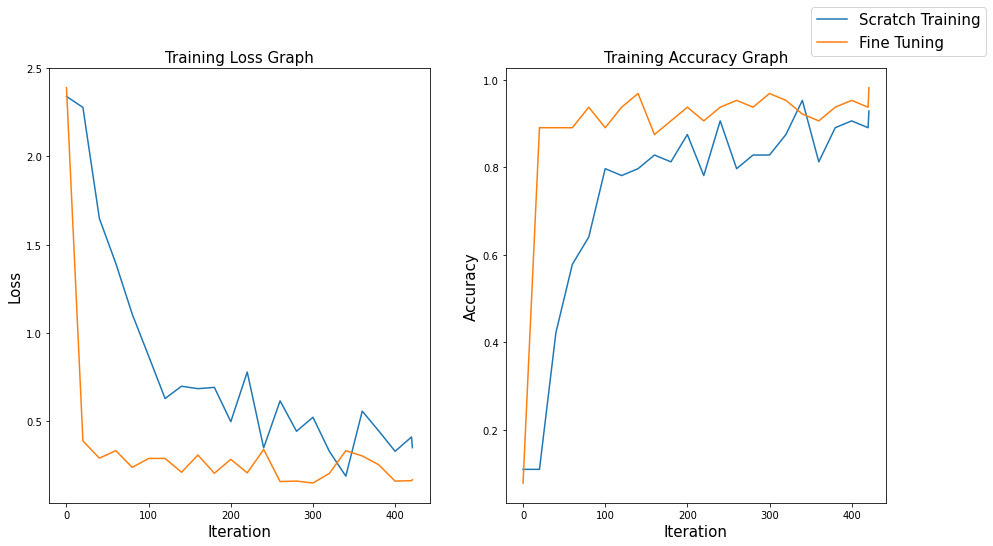

In [65]:
# Visualize training log
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))

ax1.plot(scratch_train_log.iloc[:,0], label='Scratch Training')
ax1.plot(fine_tuned_train_log.iloc[:,0], label='Fine Tuning')
ax1.set_title('Training Loss Graph', fontsize=15)
ax1.set_xlabel('Iteration', fontsize=15)
ax1.set_ylabel('Loss', fontsize=15)

fig.legend(fontsize=15)

ax2.plot(scratch_train_log.iloc[:,1], label='Scratch Training')
ax2.plot(fine_tuned_train_log.iloc[:,1], label='Fine Tuning')
ax2.set_title('Training Accuracy Graph', fontsize=15)
ax2.set_xlabel('Iteration', fontsize=15)
ax2.set_ylabel('Accuracy', fontsize=15)

plt.show()

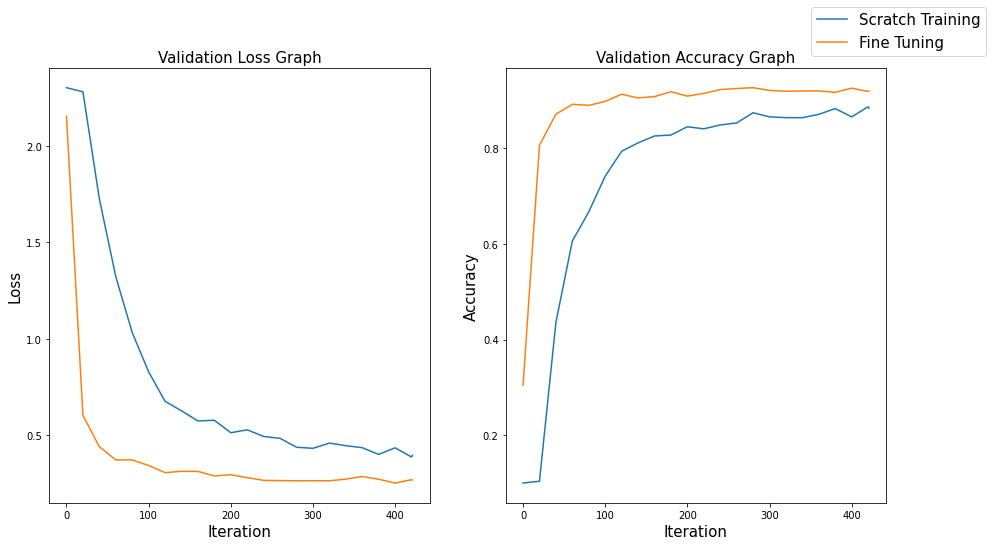

In [66]:
# Visualize validation log
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))

ax1.plot(scratch_train_log.iloc[:,2], label='Scratch Training')
ax1.plot(fine_tuned_train_log.iloc[:,2], label='Fine Tuning')
ax1.set_title('Validation Loss Graph', fontsize=15)
ax1.set_xlabel('Iteration', fontsize=15)
ax1.set_ylabel('Loss', fontsize=15)

fig.legend(fontsize=15)

ax2.plot(scratch_train_log.iloc[:,3], label='Scratch Training')
ax2.plot(fine_tuned_train_log.iloc[:,3], label='Fine Tuning')
ax2.set_title('Validation Accuracy Graph', fontsize=15)
ax2.set_xlabel('Iteration', fontsize=15)
ax2.set_ylabel('Accuracy', fontsize=15)

plt.show()